---- MADRS prediction 16h segments baseline ----

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import RobustScaler

import os
import sys
import random

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Nadam, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential, load_model

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import optimizers

import math

import xgboost as xgb
from xgboost import cv

In [6]:
# hyperparameters

step = 60 
batch_size = 16
optimizer = optimizers.Adam(lr = 0.00001) # learning rate is very low, otherwise the gradients exploded
verbose = 1
data_dir = "Downloads/depression_data"
segment_length = 960
learning_rate = 0.0001

Function for creating the segments and corresponding labels for MADRS prediction

- it will read scores.csv (with all the demographics etc), and generates: -> one list of time sliced sequences -> one list of the corresponding participants' labels (madrs scores)



In [7]:
def segments_and_labels(dataset_dir, segment_length, step):
    scores = pd.read_csv(os.path.join(dataset_dir, 'scores.csv'))
    scores['madrs2'].fillna(0, inplace=True)

    segments = []
    labels = []

    for person in scores['number']:
        p = scores[scores['number'] == person]
        filepath = os.path.join(dataset_dir, person.split('_')[0], f'{person}.csv')
        df_activity = pd.read_csv(filepath)

        for i in range(0, len(df_activity) - segment_length, step):
            segment = df_activity['activity'].values[i : i + segment_length]
            
            segments.append([segment])
            labels.append(p['madrs2'].values[0])

    segments = np.asarray(segments)
    segments = segments.reshape(-1, segment_length, 1)

    input_shape = segments.shape[1]
    segments = segments.reshape(segments.shape[0], input_shape).astype('float32')
    labels = np.asarray(labels).astype('float32')

    return segments, labels, input_shape

print(segments_and_labels(data_dir,segment_length,step))

(array([[  0., 143.,   0., ...,   0.,   0.,   0.],
       [306., 286.,  12., ...,   0.,   0.,   0.],
       [  0.,   0.,  21., ...,   0.,   0.,   9.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32), array([19., 19., 19., ...,  0.,  0.,  0.], dtype=float32), 960)


In [8]:
segments, labels, input_shape = segments_and_labels(data_dir,segment_length,step)

In [9]:
sc = RobustScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)
y_train_scaled = sc.fit_transform(y_train.reshape(-1,1))
y_test_scaled = sc.fit_transform(y_test.reshape(-1,1))

print(X_train_scaled.shape)
print()
print(X_test_scaled.shape)
print()
print(y_train_scaled.shape)
print()
print(y_test_scaled.shape)

NameError: name 'X_train' is not defined

In [10]:
X_train_scaled = sc.fit_transform(segments)
y_train_scaled = sc.fit_transform(labels.reshape(-1,1))

In [11]:
y_train = labels.reshape(-1,1)

In [12]:
print(X_train_scaled.shape)
print(y_train_scaled.shape)

(25341, 960)
(25341, 1)


In [13]:
data_dmatrix = xgb.DMatrix(data=segments,label=y_train)
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

In [14]:
xgb_cv = cv(dtrain=data_dmatrix,  
            nfold=3,
            params=params,
            num_boost_round=150, 
            early_stopping_rounds=10, 
            metrics="rmse", 
            as_pandas=True, 
            seed=123)

In [16]:
# contains train and test rmse metrics for each boosting round.
print("last 5 rmse scores of training set:\n")
h16 = xgb_cv["train-rmse-mean"]
print()
print("last 5 rmse scores of test set:\n")
h16_val = xgb_cv["test-rmse-mean"]

last 5 rmse scores of training set:


last 5 rmse scores of test set:



In [18]:
print(xgb_cv["train-rmse-mean"])

0      11.202012
1      10.806974
2      10.468578
3      10.186545
4       9.946518
         ...    
145     6.476926
146     6.466973
147     6.456717
148     6.445863
149     6.432834
Name: train-rmse-mean, Length: 150, dtype: float64


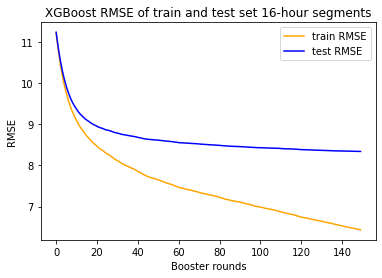

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(xgb_cv["train-rmse-mean"], color = 'orange')
plt.plot(xgb_cv["test-rmse-mean"], color = 'b')
plt.xlabel('Booster rounds')
plt.ylabel('RMSE')
plt.legend(['train RMSE','test RMSE'])
plt.title('XGBoost RMSE of train and test set 16-hour segments')
plt.show()



-------- 24h regression xgboost -----------



In [19]:
segment_length = 1440

In [20]:
segments, labels, input_shape = segments_and_labels(data_dir,segment_length,step)

In [21]:
print(segments.shape)
print(labels.shape)

(24901, 1440)
(24901,)


In [22]:
y_train = labels.reshape(-1,1)
print(y_train.shape)

(24901, 1)


In [23]:
data_dmatrix = xgb.DMatrix(data=segments,label=y_train)
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

In [24]:
xgb_cv = cv(dtrain=data_dmatrix,  
            nfold=3,
            params=params,
            num_boost_round=150, 
            early_stopping_rounds=10, 
            metrics="rmse", 
            as_pandas=True, 
            seed=123)

In [25]:
# contains train and test rmse metrics of last 5 boosting rounds.
print("last 5 rmse scores of training set:\n")
h24 = xgb_cv["train-rmse-mean"]
print()
print("last 5 rmse scores of test set:\n")
h24_val = xgb_cv["test-rmse-mean"]

last 5 rmse scores of training set:


last 5 rmse scores of test set:



In [26]:
print(xgb_cv["train-rmse-mean"])

0      11.174042
1      10.768722
2      10.418753
3      10.136332
4       9.891802
         ...    
145     6.189200
146     6.176281
147     6.163463
148     6.149242
149     6.140689
Name: train-rmse-mean, Length: 150, dtype: float64


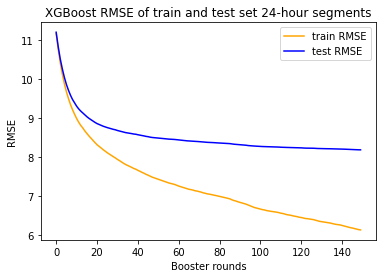

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(xgb_cv["train-rmse-mean"], color = 'orange')
plt.plot(xgb_cv["test-rmse-mean"], color = 'b')
plt.xlabel('Booster rounds')
plt.ylabel('RMSE')
plt.legend(['train RMSE','test RMSE'])
plt.title('XGBoost RMSE of train and test set 24-hour segments')
plt.show()

-------- 48h regression xgboost -----------

In [28]:
segment_length = 2880

In [31]:
segments, labels, input_shape = segments_and_labels(data_dir,segment_length,step)
print(segments.shape)
print(labels.shape)
y_train = labels.reshape(-1,1)
print(y_train.shape)

(23581, 2880)
(23581,)
(23581, 1)


In [32]:
data_dmatrix = xgb.DMatrix(data=segments,label=y_train)
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,
          'learning_rate': 0.1,'max_depth': 5,'alpha': 10}

In [33]:
xgb_cv = cv(dtrain=data_dmatrix,  
            nfold=3,
            params=params,
            num_boost_round=150, 
            early_stopping_rounds=10, 
            metrics="rmse", 
            as_pandas=True, 
            seed=123)

In [34]:
# contains train and test rmse metrics of last 5 boosting rounds.
print("last 5 rmse scores of training set:\n")
h48 = xgb_cv["train-rmse-mean"]
print()
print("last 5 rmse scores of test set:\n")
h48_val = xgb_cv["test-rmse-mean"]

last 5 rmse scores of training set:


last 5 rmse scores of test set:



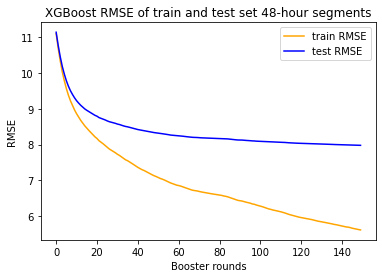

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(xgb_cv["train-rmse-mean"], color = 'orange')
plt.plot(xgb_cv["test-rmse-mean"], color = 'b')
plt.xlabel('Booster rounds')
plt.ylabel('RMSE')
plt.legend(['train RMSE','test RMSE'])
plt.title('XGBoost RMSE of train and test set 48-hour segments')
plt.show()

-------- 72h regression xgboost -----------

In [36]:
segment_length = 4320

In [37]:
segments, labels, input_shape = segments_and_labels(data_dir,segment_length,step)
print(segments.shape)
print(labels.shape)
y_train = labels.reshape(-1,1)
print(y_train.shape)

(22261, 4320)
(22261,)
(22261, 1)


In [38]:
data_dmatrix = xgb.DMatrix(data=segments,label=y_train)
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,
          'learning_rate': 0.1,'max_depth': 5,'alpha': 10}

In [39]:
xgb_cv = cv(dtrain=data_dmatrix,  
            nfold=3,
            params=params,
            num_boost_round=150, 
            early_stopping_rounds=10, 
            metrics="rmse", 
            as_pandas=True, 
            seed=123)

In [40]:
# contains train and test rmse metrics of last 5 boosting rounds.
print("last 5 rmse scores of training set:\n")
h72 = xgb_cv["train-rmse-mean"]
print()
print("last 5 rmse scores of test set:\n")
h72_val = xgb_cv["test-rmse-mean"]

last 5 rmse scores of training set:


last 5 rmse scores of test set:



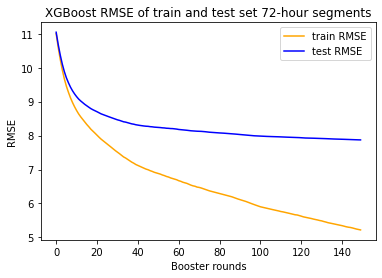

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(xgb_cv["train-rmse-mean"], color = 'orange')
plt.plot(xgb_cv["test-rmse-mean"], color = 'b')
plt.xlabel('Booster rounds')
plt.ylabel('RMSE')
plt.legend(['train RMSE','test RMSE'])
plt.title('XGBoost RMSE of train and test set 72-hour segments')
plt.show()

-------- 96h regression xgboost -----------

In [42]:
segment_length = 5760

In [43]:
segments, labels, input_shape = segments_and_labels(data_dir,segment_length,step)
print(segments.shape)
print(labels.shape)
y_train = labels.reshape(-1,1)
print(y_train.shape)

(20941, 5760)
(20941,)
(20941, 1)


In [44]:
data_dmatrix = xgb.DMatrix(data=segments,label=y_train)
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,
          'learning_rate': 0.1,'max_depth': 5,'alpha': 10}

In [46]:
xgb_cv = cv(dtrain=data_dmatrix,  
            nfold=3,
            params=params,
            num_boost_round=150, 
            early_stopping_rounds=10, 
            metrics="rmse", 
            as_pandas=True, 
            seed=123)

In [47]:
# contains train and test rmse metrics of last 5 boosting rounds.
print("last 5 rmse scores of training set:\n")
print(xgb_cv["train-rmse-mean"])
print()
print("last 5 rmse scores of test set:\n")
print(xgb_cv["test-rmse-mean"].tail())

last 5 rmse scores of training set:

0      10.905917
1      10.500819
2      10.145283
3       9.839869
4       9.574243
         ...    
145     4.949265
146     4.932057
147     4.915013
148     4.899543
149     4.891471
Name: train-rmse-mean, Length: 150, dtype: float64

last 5 rmse scores of test set:

145    7.809691
146    7.806802
147    7.803797
148    7.801474
149    7.799926
Name: test-rmse-mean, dtype: float64


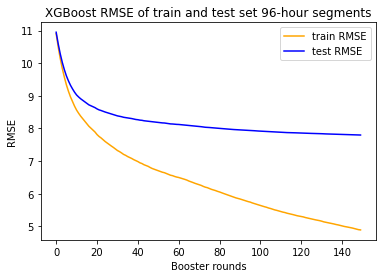

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(xgb_cv["train-rmse-mean"], color = 'orange')
plt.plot(xgb_cv["test-rmse-mean"], color = 'b')
plt.xlabel('Booster rounds')
plt.ylabel('RMSE')
plt.legend(['train RMSE','test RMSE'])
plt.title('XGBoost RMSE of train and test set 96-hour segments')
plt.show()

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [50]:

h96 = xgb_cv["train-rmse-mean"]

Text(0.5, 1.0, 'XGBoost training RMSE per booster round (3-fold cross-validation)')

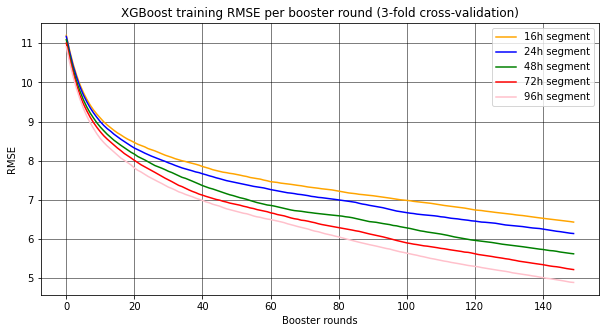

In [51]:
%matplotlib inline

plt.figure(figsize=(10, 5))
plt.grid(color='k', linestyle='-', linewidth=0.5)
#plt.plot(range(1, len(h24) + 1), h24, color = 'b', marker = 'x')
#plt.plot(range(1, len(h48) + 1), h48, color = 'green', marker = 's')
#plt.plot(range(1, len(h72) + 1), h72, color = 'red', marker = 'D')
plt.plot(h16, color = 'orange')
plt.plot(h24, color = 'blue')
plt.plot(h48, color = 'green')
plt.plot(h72, color = 'red')
plt.plot(h96, color = 'pink')
plt.xlabel('Booster rounds')
plt.ylabel('RMSE')
plt.legend(['16h segment','24h segment','48h segment','72h segment','96h segment'])
plt.title('XGBoost training RMSE per booster round (3-fold cross-validation)')


